In [1]:
import pybroker as pb
from pybroker.ext.data import AKShare
import akshare as ak
from pybroker import Strategy, StrategyConfig, ExecContext
from backtest import get_last_invest
import pandas as pd
from loguru import logger

pb.enable_data_source_cache('my_strategy')

/home/liubei/miniconda3/envs/turtle/lib/python3.12/site-packages/py_mini_racer/py_mini_racer.py:15: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
2026-01-11 17:51:29.924523094 [W:onnxruntime:Default, device_discovery.cc:164 DiscoverDevicesForPlatform] GPU device discovery failed: device_discovery.cc:89 ReadFileContents Failed to open file: "/sys/class/drm/card0/device/vendor"


In [2]:
# 定义全局参数 "stock_code"（股票代码）、"percent"（持仓百分比）和 "stop_profit_pct"（止盈百分比）
pb.param(name='stock_code', value='601601')
pb.param(name='percent', value=1)
pb.param(name='stop_loss_pct', value=10)
pb.param(name='stop_profit_pct', value=10)

# 1. 启用缓存（可选）
pb.enable_data_source_cache("all_in_cache")
pb.enable_indicator_cache("all_in_ind")

In [3]:
config = StrategyConfig(initial_cash=20000)

In [4]:
strategy = Strategy(AKShare(), '1/1/2025', '7/1/2025', config)

In [5]:
def get_yesterday_trade_date(date):
    # 交易日历
    trade_df = ak.tool_trade_date_hist_sina()
    trade_df["trade_date"] = pd.to_datetime(trade_df["trade_date"], errors='coerce')
    trade_list = trade_df["trade_date"].dt.strftime('%Y%m%d').to_list()
    index = trade_list.index(date)
    return trade_list[index-1]

In [6]:
def buy_with_stop_loss(ctx: ExecContext):
    cur_date = ctx.date[-1].astype('datetime64[D]').item().strftime('%Y%m%d')
    yesterday = get_yesterday_trade_date(cur_date)
    logger.info(f"当前交易日：{cur_date}, 前一天：{yesterday}")
    _, invest_json = get_last_invest(yesterday)
    pos = ctx.long_pos()
    if not invest_json:
        return
    else:
        if not pos:
            if invest_json["user_not_held"] == "buy":
                logger.info("buy buy buy")
            # 计算目标股票数量，根据 "percent" 参数确定应购买的股票数量
                ctx.buy_shares = ctx.calc_target_shares(pb.param(name='percent'))
                ctx.hold_bars = 100
        else:
            if invest_json["user_held"] == "sell":
                logger.info("sell sell sell")
                ctx.sell_all_shares()
            elif invest_json["user_held"] == "wait":
                ctx.sell_shares = pos.shares
                # 设置止盈点位，根据 "stop_profit_pct" 参数确定止盈点位
                ctx.stop_profit_pct = pb.param(name='stop_profit_pct')
                ctx.stop_loss_pct = pb.param(name='stop_loss_pct')

In [7]:
strategy.add_execution(buy_with_stop_loss,  symbols=[pb.param(name='stock_code')])

In [8]:
result = strategy.backtest()

Backtesting: 2025-01-01 00:00:00 to 2025-07-01 00:00:00

Loaded cached bar data.

Test split: 2025-01-02 00:00:00 to 2025-07-01 00:00:00


  0% (0 of 118) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--2026-01-11 17:51:31.797 | INFO     | __main__:buy_with_stop_loss:4 - 当前交易日：20250102, 前一天：20241231
2026-01-11 17:51:31.798 | WARNING  | backtest:get_last_invest:14 - 20241231历史数据不存在
  0% (1 of 118) |                        | Elapsed Time: 0:00:00 ETA:   0:00:352026-01-11 17:51:31.963 | INFO     | __main__:buy_with_stop_loss:4 - 当前交易日：20250103, 前一天：20250102
2026-01-11 17:51:31.964 | WARNING  | backtest:get_last_invest:14 - 20250102历史数据不存在
2026-01-11 17:51:32.148 | INFO     | __main__:buy_with_stop_loss:4 - 当前交易日：20250106, 前一天：20250103
2026-01-11 17:51:32.150 | WARNING  | backtest:get_last_invest:14 - 20250103历史数据不存在
2026-01-11 17:51:32.328 | INFO     | __main__:buy_with_stop_loss:4 - 当前交易日：20250107, 前一天：20250106
2026-01-11 17:51:32.330 | WARNING  | backtest:get_last_invest:14 - 20250106历史数据不存在
2026-01-11 17:51:32.495 | INFO     | __main__:buy_with_stop_loss:4 - 当前交易日：20250108, 前一天：20250107
2026-01-11 17:51:32.


Finished backtest: 0:00:29


### 查看投资组合的每日余额

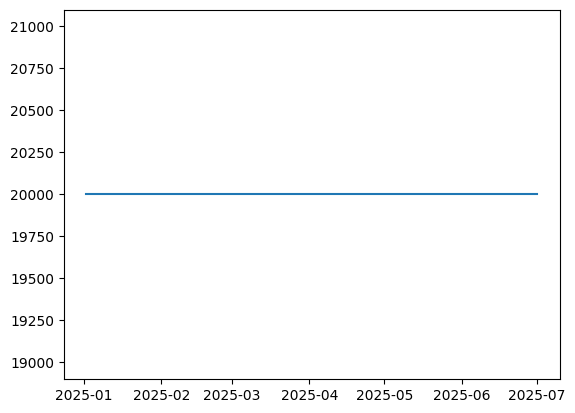

In [9]:
import matplotlib.pyplot as plt

chart = plt.subplot2grid((3, 2), (0, 0), rowspan=3, colspan=2)
chart.plot(result.portfolio.index, result.portfolio['market_value'])

In [10]:
result.portfolio

,cash,equity,margin,market_value,pnl,unrealized_pnl,fees
date,,,,,,,
2025-01-02,20000.0,20000.0,0.0,20000.0,0.0,0.0,0.0
2025-01-03,20000.0,20000.0,0.0,20000.0,0.0,0.0,0.0
2025-01-06,20000.0,20000.0,0.0,20000.0,0.0,0.0,0.0
2025-01-07,20000.0,20000.0,0.0,20000.0,0.0,0.0,0.0
2025-01-08,20000.0,20000.0,0.0,20000.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
2025-06-25,20000.0,20000.0,0.0,20000.0,0.0,0.0,0.0
2025-06-26,20000.0,20000.0,0.0,20000.0,0.0,0.0,0.0
2025-06-27,20000.0,20000.0,0.0,20000.0,0.0,0.0,0.0


### 持仓

In [11]:
result.positions

,,long_shares,short_shares,close,equity,market_value,margin,unrealized_pnl
symbol,date,,,,,,,


In [12]:
result.trades

,type,symbol,entry_date,exit_date,entry,exit,shares,pnl,return_pct,agg_pnl,bars,pnl_per_bar,stop,mae,mfe
id,,,,,,,,,,,,,,,


In [13]:
result.orders

,type,symbol,date,shares,limit_price,fill_price,fees
id,,,,,,,


In [14]:
result.metrics_df

,name,value
0,trade_count,0.0
1,initial_market_value,20000.0
2,end_market_value,20000.0
3,total_pnl,0.0
4,unrealized_pnl,0.0
5,total_return_pct,0.0
6,total_profit,0.0
7,total_loss,0.0
8,total_fees,0.0
9,max_drawdown,-0.0
